Pure HelmholtzI Uniformity
=========================

Study the uniformity of a pure Helmholtz model for comparison with more realistic coils.

This uses the FEMME model H0I which puts point 400A currents at x=50cm, y=$\pm$25cm in a 1m radius sphere with all default boundary conditions.  The results look strange near the walls, where the field is pulled into the wall.

Start by loading some tools, including a set of FieldTools written specially for this task.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import femm

In [2]:
import FieldGrids as fp

Now we start up FEMME and tell it to open the (already run) Helmholtz simulation.

In [3]:
femm.openfemm()
femm.opendocument('H0I.ans')

Just to prove the point, let's pull data out from a point and print it.

In [4]:
_,B0 = femm.mo_getb(0.0,0.0)
print(B0)

0.0007821999886293991


That gives us the field at the center of the Helmholtz coil, about 0.17 Gauss.

Visualizing the field
---------------------

No let's use the FieldGrids system to pull a region of data from the center of the system.
I first have to build a grid.

In [5]:
lg = fp.Grid(xlow=0.0,xhigh=15.0,dx=0.1,ylow=-15.0,yhigh=15.0,dy=0.1)

Then I can ask for the field. I am pulling out both Bx and By which will become the u and v components of the vector field, respectively. Pulling data out is rather slow so I want to get it all at once.

In [6]:
b = fp.VectorField(lg)
b.LoadFemm()

True

Now I can plot the field using the quiver plot from matplotlib. I ask for arrows spaced 20 points apart.

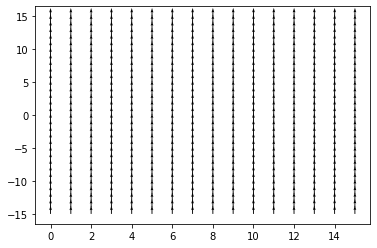

In [7]:
b.VPlot(10)

That looks like very much what we would expect for a uniformn field.

We can see the little wiggles if we make a copy of the field and blow up the x component.

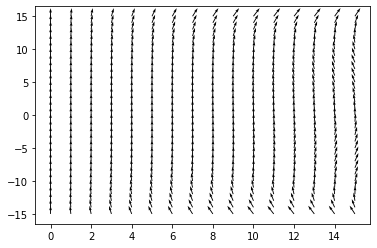

In [8]:
zb = fp.VectorField(b)
zb.u *= 100
zb.VPlot(10)

So we get a believable field, though the representation is a little odd since the arrow heads do NOT mark a field line. We get a more normal view if we plot field lines.

<AxesSubplot:>

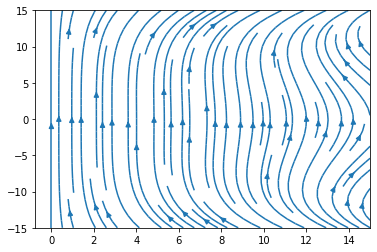

In [9]:
zb.StreamPlot()

That gives us a rather more intuitive sense of the field shape, though we have to remember that the horizontal deviations have been enlarged 100 fold.

Another way to look at the field is to plot the magitude of the field. FieldGrids provides a method to get the magnitude of the field (the square root of of the dot product of the field with itself) as a new scalar field, which we can plot as a surface.

<Axes3DSubplot:>

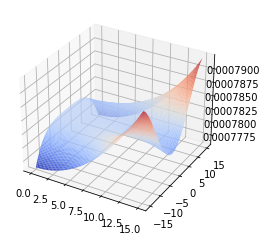

In [10]:
bmag = b.Mag()
bmag.Splot(2)

In [11]:
print(np.max(b.u),np.max(b.v))

6.197315267328576e-06 0.0007922257117732687


It is clear that by 15 cm away from the center, especially near the diagonals, we are getting some large deviations from uniformity. The maximum field in the region is about 0.23 Gauss compared to the 0.17 Gauss at the center. This is a 35% change. We are mostly interested in the central region.

We get another look if we make a contour plot of the field. I am plotting the *difference* between the actual field and the central field as a fraction of the central field.

<AxesSubplot:>

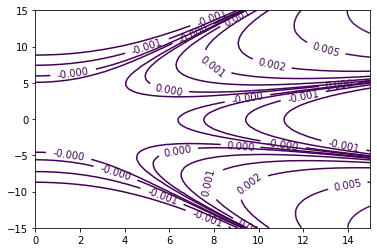

In [12]:
bmd = fp.ScalarField(bmag)
bmd.u -= B0
bmd.u /= B0
bmd.Cplot([-1e-3,-5e-4,-2e-4,-1e-4,1e-4,2e-4,5e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1,2e-1])

It would be nice if the contours were colored by the sign of the difference but I think that the shape is clear. We see that there is a central region where the deviation is within the $10^-4$ limit.

The Non-Uniform Part of the Field
---------------------------------

A more instructive view is to look at the magnitude of the difference between this field magnitude and a uniform field matching the center value. I start by constructing this difference field and scale it to the central field. This gives us values which are fractional deviations from the central field. They are easier to interpret.

<Axes3DSubplot:>

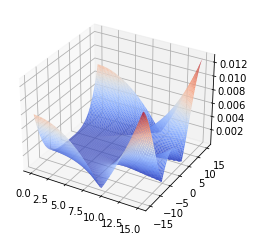

In [13]:
bmagdiff = fp.ScalarField(bmag)
bmagdiff.u = np.abs(bmagdiff.u - B0 + 1e-9)
bmagdiff.u /= B0
bmagdiff.Splot(2)

So that agrees with the previous plot and we can now look it at in a contour plot with logarithmic contour levels, which should strongly resemble the previous contour plot.

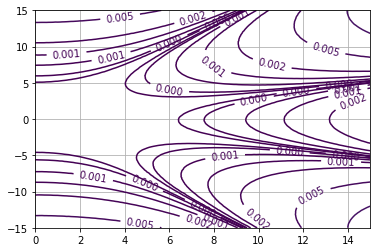

In [14]:
cax = bmagdiff.Cplot([1e-4,2e-4,5e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1,2e-1])
cax.grid(axis='both')

Now that is rather nice. It allows to come up with an approximate radius for the largest sphere within which the field is flat at the 10^-4 level.

Because the axes are not symmetric this is a little harder than it needs to be. We can make it easier by adding a second set of contours which are actual circles centered on the origin. We start with a scalar field of value r.

<AxesSubplot:>

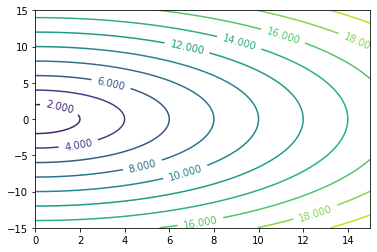

In [15]:
rf = fp.ScalarField(bmag)
rf.u = np.sqrt(rf.x * rf.x + rf.y * rf.y)
rf.Cplot()

Now let's see if we can overlay these two fields.

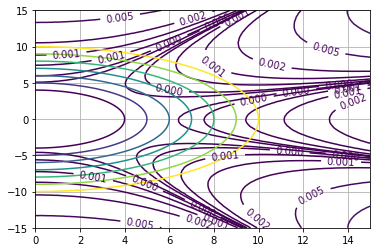

In [16]:
cax = bmagdiff.Cplot([1e-4,2e-4,5e-4,1e-3,2e-3,5e-3,1e-2,2e-2,5e-2,1e-1,2e-1])
cax.grid(axis='both')
cax.contour(rf.x,rf.y,rf.u,levels=[4.0, 5.0,6,7,8,9,10])

CUTE! That worked well enough for us to see that the sphere has radius between 4 and 5. It is now apparent that we have some iny asymmetry in the z direction as the valid region extends 6 cm up the z axis but only about 5.3 cm below it. In other directions we are more in the 6-7 cm area. 

I can find no source of asymmetry in the field model so this must somehow arise from an asymmetry in the solution method. We can explore it a little further by plotting the field on axis both forwards and backwards on the same graph.

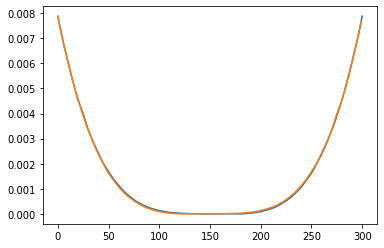

In [17]:
plt.plot(bmagdiff.u[:,0])
plt.plot(bmagdiff.u[-1:0:-1,0])

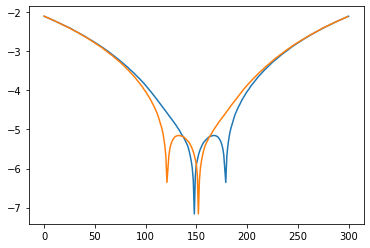

In [18]:
plt.plot(np.log10(bmagdiff.u[:,0]))
plt.plot(np.log10(bmagdiff.u[-1:0:-1,0]))

Well, there is an asymmetry. Looking at the bottom in detail we see that the center of the pattern, the actualtip of the field bump, was slightly to one side of the center.

(0.0, 0.0001)

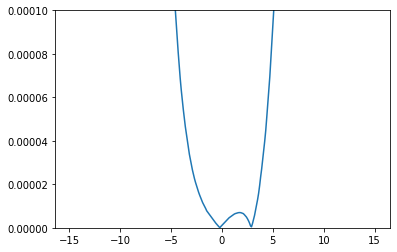

In [19]:
plt.plot(bmagdiff.y[-1:0:-1,0], bmagdiff.u[-1:0:-1,0])
plt.ylim((0,0.0001))

So there is about a 2cm shift of the position of the center from where we would expect it. That is REALLY weird. Examining the source file I see that all the wire and box positions are exactly correct. How is FEMME giving us a shift of the center?

So this gives exactly the same shift as H0 did!